<h1> Process OMEGA FOOF </h1>

This notebook is for processing FOOF results of a single subject. 
- Loads pickled object of saved FOOF results from OMEGA
- Select information of interest
- Saves mat file with selected information for visualization

In [8]:
#import sys
import os
import numpy as np
import scipy.io as sio
import pickle
import matplotlib.pyplot as plt

#
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
from scipy.stats.stats import pearsonr

%matplotlib inline

In [9]:
# Set Paths
foof_data_path = '/Users/thomasdonoghue/Documents/Research/1-Projects/OMEGA/2-Data/MEG/3-FOOF/'

In [10]:
# Check Availabe Subjects
files = os.listdir(foof_data_path)
files = clean_file_list(files, 'Foof_Vertex')
print files

['124340_Foof_Vertex.p', '220216_Foof_Vertex.p', '265922_Foof_Vertex.p', '320548_Foof_Vertex.p', '369737_Foof_Vertex.p', '390845_Foof_Vertex.p']


In [11]:
# Set Subject to Run
cur_subj = 124340
cur_subj_file = get_cur_subj(cur_subj, files)
cur_subj_path = os.path.join('/Users/thomasdonoghue/Documents/Research/1-Projects/OMEGA/2-Data/MEG/3-FOOF/', cur_subj_file)

In [12]:
# Load results 
results = pickle.load(open(cur_subj_path, 'rb'))

In [13]:
type(results)
len(results)
results[0]

(0.63299064348395762,
 array([ 11.53619584,  16.37922656,  19.57503166,  23.49225133,  36.23398889]),
 array([  3.32118864e-23,   1.63446648e-23,   1.52059724e-23,
          1.28753042e-23,   8.33725623e-24]),
 array([ 0.80134726,  1.03479212,  1.04571927,  2.10439096,  1.56634069]))

In [14]:
# Check number of PSDs
nPSDs = len(results)

# Initialize numpy arrays to pull out different result params
slopes_all = np.zeros([nPSDs, 1])
centers_all = np.zeros([nPSDs, 8])
powers_all = np.zeros([nPSDs, 8])
stdevs_all = np.zeros([nPSDs, 8])

# Loop through FOOF results, pulling out individual findings
for i in range(0, nPSDs):
    slopes_all[i, 0] = results[i][0]
    centers_all[i, 0:len(results[i][1])] = results[i][1]
    powers_all[i, 0:len(results[i][2])] = results [i][2]
    stdevs_all[i, 0:len(results[i][3])] = results[i][3]
    
print nPSDs

7500


In [15]:
# Oscillation Parameters
theta_low = 3
theta_high = 8
alpha_low = 8
alpha_high = 13
beta_low = 13
beta_high = 30

# Initialize vectors to save results
thetas_cen = np.zeros([nPSDs, 1])
thetas_power = np.zeros([nPSDs, 1])
thetas_bw = np.zeros([nPSDs, 1])
n_thetas = np.zeros([nPSDs,1])

alphas_cen = np.zeros([nPSDs, 1])
alphas_power = np.zeros([nPSDs, 1])
alphas_bw = np.zeros([nPSDs, 1])
n_alphas= np.zeros([nPSDs, 1])

betas_cen = np.zeros([nPSDs, 1])
betas_power = np.zeros([nPSDs, 1])
betas_bw = np.zeros([nPSDs, 1])
n_betas =np.zeros([nPSDs, 1])

centers_vect = []
powers_vect = []
bws_vect = []

# Collect Oscillations
for i in range(0, nPSDs):

    centers_temp = centers_all[i, :]
    powers_temp = powers_all[i, :]
    bws_temp = stdevs_all[i, :]
    
    centers_vect = np.append(centers_vect, centers_temp[centers_temp > 0])
    powers_vect = np.append(powers_vect, powers_temp[powers_temp > 0])
    bws_vect = np.append(bws_vect, bws_temp[bws_temp > 0])
    
    thetas_cen[i, 0], thetas_power[i, 0], thetas_bw[i, 0], n_thetas[i, 0] = get_osc(centers_temp, 
                                                                                  powers_temp, 
                                                                                  bws_temp, 
                                                                                  theta_low, 
                                                                                  theta_high)
    alphas_cen[i, 0], alphas_power[i, 0], alphas_bw[i, 0], n_alphas[i, 0] = get_osc(centers_temp, 
                                                                                  powers_temp, 
                                                                                  bws_temp, 
                                                                                  alpha_low, 
                                                                                  alpha_high)
    betas_cen[i, 0],  betas_power[i, 0],  betas_bw[i, 0],  n_betas[i, 0]  = get_osc(centers_temp, 
                                                                                  powers_temp, 
                                                                                  bws_temp, 
                                                                                  beta_low, 
                                                                                  beta_high)

In [4]:
def get_osc(centers, power, bw, osc_low, osc_high):
    
    osc_inds = (centers_temp > osc_low) & (centers_temp < osc_high)
    
    osc_cen = centers[osc_inds]
    osc_power = power[osc_inds]
    osc_bw = bw[osc_inds]
    
    cen, n = get_single_osc(osc_cen)
    power, x = get_single_osc(osc_power)
    bw, x = get_single_osc(osc_bw)
    
    return cen, power, bw, n

In [ ]:
savepath = '/Users/thomasdonoghue/Documents/Research/1-Projects/OMEGA/2-Data/MEG/4-Viz/'
savename = str(cur_subj) + '_Foof_Viz'
savefile = os.path.join(savepath, savename)

save_dict = {}
save_dict['slopes']= slopes_all
save_dict['thetas']= thetas_bw
save_dict['alphas']= alphas_bw
save_dict['betas']= betas_bw

sio.savemat(savefile, save_dict)

In [5]:
def clean_file_list(files_in, string):
    '''Takes a list of file names (strings), returns only those with 'string' in them.'''
    
    files_out = []

    for i in range(0, len(files_in)):
        if(string in files_in[i]):
            files_out.append(files_in[i])
            
    return files_out

In [6]:
def get_single_osc(osc_in):
    '''Takes a vector, returns the first element, and the length.'''
    
    if(len(osc_in) == 0):
        return 0, 0
    elif(len(osc_in) == 1):
        return osc_in, 1
    else:
        return osc_in[0], len(osc_in)

In [7]:
def get_cur_subj(cur_subj, files):
    '''Takes an int, and a list of file names (strings), returns the file name with the number in it.'''
    
    cur_subj_str = str(cur_subj)
    
    for i in range(0, len(files)):
        if(cur_subj_str in files[i]):
            return files[i]

In [16]:
print min(n_alphas)
print max(n_alphas)

print np.median(n_alphas)
print np.mean(n_alphas)

[ 0.]
[ 3.]
1.0
0.9108


In [17]:
len(centers_vect)

20970

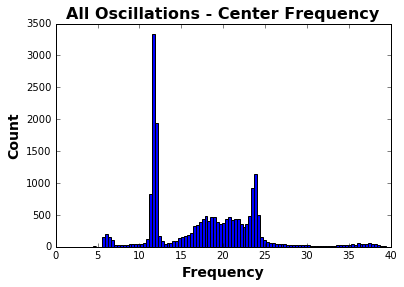

In [18]:
# Histogram of all oscillations center frequency
hist_data = plt.hist(centers_vect, 100)
plt.title('All Oscillations - Center Frequency', {'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Frequency', {'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Count', {'fontsize': 14, 'fontweight': 'bold'})

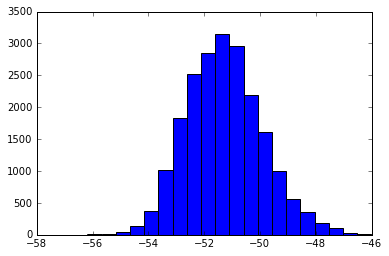

In [19]:
# Histogram of all oscillations power
hist_data = plt.hist(np.log(powers_vect), 20)

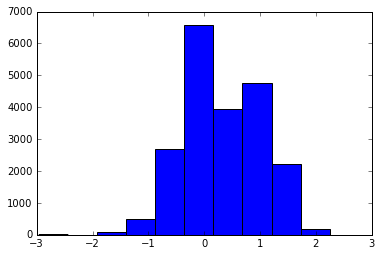

In [20]:
#  Histogram of all oscillations bandwidth
hist_data = plt.hist(np.log(bws_vect))

In [ ]:
#thetas_inds = (centers_temp > theta_low) & (centers_temp < theta_high)
#thetas_cen_temp = centers_temp[thetas_inds]
#thetas_amp_temp = bw_temp[thetas_inds]
#thetas_bw_temp = power_temp[thetas_inds]
    
#thetas_temp = centers_temp[centers_temp > theta_low]; thetas_temp = thetas_temp[thetas_temp < theta_high]

#thetas_cen[i, 0], n_thetas[i, 0] = get_single_osc(thetas_cen_temp)
#thetas_amp[i, 0], x = get_single_osc(thetas_amp_temp)
#thetas_bw[i, 0], x = get_single_osc(thetas_bw_temp)
    
#alphas_temp = centers_temp[centers_temp > alpha_low]; alphas_temp = alphas_temp[alphas_temp < alpha_high]
#alphas_cen[i, 0], n_alphas[i, 0] = get_single_osc(alphas_temp)
    
#betas_temp = centers_temp[centers_temp > beta_low]; betas_temp = betas_temp[betas_temp < beta_high]
#betas_cen[i, 0], n_betas[i, 0] = get_single_osc(betas_temp)

In [21]:
print min(bws_vect)
print max(bws_vect)
print np.mean(bws_vect)
print np.median(bws_vect)

0.0519109453494
9.48775792171
1.7391175396
1.27720181171


In [25]:
nPSDs

7500

In [26]:
KMeans?

In [27]:
# K-Means Clustering of oscillations

# Put data together
dat = np.vstack([centers_vect, powers_vect, bws_vect]).T
np.shape(dat)

# Initialize Things
inertias = []
k_min = 2
k_max = 20

# Fit K-means
for i in range(k_min, k_max):
    
    # Initialize K means
    km = KMeans(n_clusters = i, init='k-means++', n_init=10, max_iter=300)   
    
    km.fit(dat)
    
    inertias = np.append(inertias, km.inertia_)

In [28]:
inertias

array([ 296681.28542466,  149829.34161342,   81075.39880139,
         61675.83098778,   45185.27572789,   37613.72439746,
         31876.92283036,   27348.43432242,   24910.71346239,
         22560.18738293,   20383.00361252,   18510.4002311 ,
         17089.04926108,   15786.35208716,   14864.48385295,
         13910.86475551,   13123.01380587,   12387.25357862])

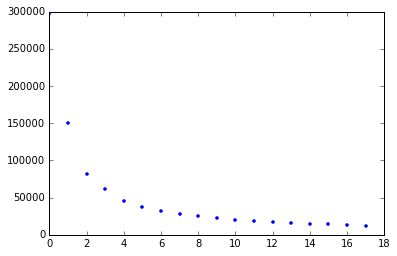

In [29]:
plt.plot(inertias, '.')

In [ ]:
# Initialize K means
n_clus = 6
km = KMeans(n_clusters = n_clus, init='k-means++', n_init=10, max_iter=300)   
km.fit(dat)

In [ ]:
km.cluster_centers_

In [ ]:
km.labels_
plt.hist(km.labels_, range(0,n_clus+1))

In [ ]:
af = AffinityPropagation()

In [ ]:
af.fit(dat)

(-0.47367981926730385, 0.0)

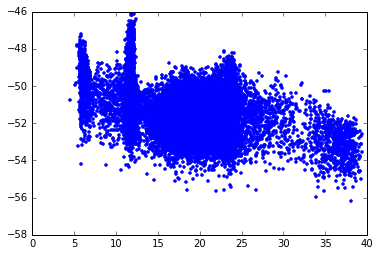

In [22]:
# Centers vs. Powers
plt.plot(centers_vect, np.log(powers_vect), '.')
pearsonr(centers_vect, np.log(powers_vect))

(-0.26299958043323896, 0.0)

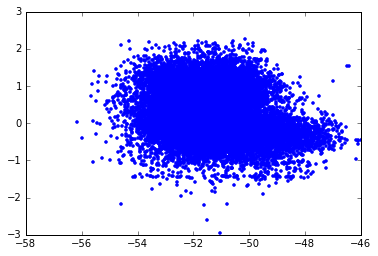

In [30]:
# Powers vs. Bandwidths
plt.plot(np.log(powers_vect), np.log(bws_vect), '.')
pearsonr(np.log(powers_vect), np.log(bws_vect))

(0.27300989641368589, 0.0)

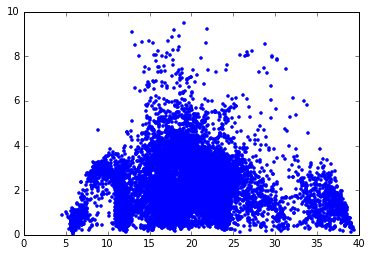

In [24]:
# Centers vs. Bandwidths
plt.plot(centers_vect, bws_vect, '.')
pearsonr(centers_vect, bws_vect)

In [ ]:
pca = PCA(n_components=2)
pca.fit(dat)
print(pca.explained_variance_ratio_) 

In [ ]:
pca.fit?

In [ ]:
np.shape(dat)

In [31]:
pearsonr?